In [46]:

#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns


#sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score


In [47]:
# Load train & test sets
train_df = pd.read_csv("UNSW_NB15_MODELS/UNSW_NB15_training-set.csv")
test_df  = pd.read_csv("UNSW_NB15_MODELS/UNSW_NB15_testing-set.csv")

train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [48]:
#Encode Categorical Columns
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()

for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))



#Split Features/Labels
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]

In [49]:
#Outlier Removal using Isolation Forest
iso = IsolationForest(contamination=0.02, random_state=42)
mask = iso.fit_predict(X_train) == 1

X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)

print("After outlier removal:", X_train.shape)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


After outlier removal: (171834, 44)


In [50]:
#SMOTE Oversampling

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

X_train, y_train = X_train_res, y_train_res


In [51]:


#Preprocessing (Standard Scaling)
numeric_cols = X_train.columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), numeric_cols)
])


from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=20, random_state=42)


In [52]:
#Logistic Regression Model
log_reg = LogisticRegression(
    max_iter=500,
    solver='lbfgs',
    n_jobs=-1
)

#Pipeline
logreg_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('pca', pca),
    ('classifier', log_reg)
])


#Train the model
logreg_pipeline.fit(X_train, y_train)


#Predict
y_pred_lr = logreg_pipeline.predict(X_test)

In [53]:
#Evaluation Metrics
acc_lr  = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=0)
rec_lr  = recall_score(y_test, y_pred_lr, average='weighted', zero_division=0)
f1_lr   = f1_score(y_test, y_pred_lr, average='weighted', zero_division=0)

print("\nLogistic Regression with PCA:\n")
print("Accuracy: ", round(acc_lr, 4))
print("Precision:", round(prec_lr, 4))
print("Recall:   ", round(rec_lr, 4))
print("F1 Score: ", round(f1_lr, 4))


Logistic Regression with PCA:

Accuracy:  0.9692
Precision: 0.9692
Recall:    0.9692
F1 Score:  0.9692


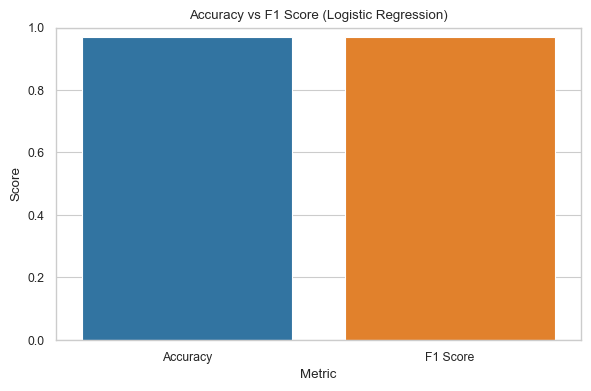

In [54]:
# Visualization - Accuracy vs F1 Score

# Apply seaborn style
sns.set_style("whitegrid")
sns.set_context("paper")

# Prepare DataFrame for plotting (using computed metrics)
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score'],
    'Value': [acc_lr, f1_lr]
})

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Metric', y='Value', data=metrics_df)
plt.title("Accuracy vs F1 Score (Logistic Regression)")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.tight_layout()
plt.show()
